# **Описание DataFrame и постановка аналитической задачи**


---


Имеется DataFrame (https://drive.google.com/file/d/1Fg3bvX2NOzd3pqcEkH8-epbZFll60-36) со статистикой игровой активности пользователей в игре жанра match3. Данная таблица содержит лог событий за определенный промежуток времени по первым 500 уровням в игре.

**Входные данные:**


1.   uid — уникальный id игрока;
2.   action — ‘completed’ для успешной попытки прохождения уровня, ‘failed’ для неуспешной;
3.   level — уровень, на котором произошло событие;
4.   event_time — event_time/1000 является unix timestamp времени получения события.


На основе представленных данных можно выявить "проблемные" уровни для пользователей нашей игры. Также было бы неплохо расчитать "воронку" прохождения уровней новым пользователем после установки игры 

**Какая выгода в проведении данного исследования для бизнеса:**

Очень важно, чтобы игрок не покидал наш проект. Если он дойдет до уровня, который не сможет пройти на протяжении какого-то времени, то ему может это просто надоесть, и мы потеряем потеницального пользователя.

Да, в игре есть бонусы, которые помогут ему пройти сложный уровень (за платную внутриигровую валюту). Но я предполагаю, что если пользователь отчаяно пытается пройти этот уровень без использования хэлперов за донат, то он не намерен оставлять деньги в нашем проекте. Но это не значит, что нужно бросать его на произвол судьбы беспощадного уровня. В нашем приложении так же предусмотрена контекстная реклама, поэтому удержание пользователя в нашем проекте (даже если он не покупает платные внутриигровые бонусы) остается актуальным.

В конце посмотрим, до каких уровней доходят наши новые пользователи на текущий момент.

**Я разбил исследование на несколько задач:**

1.   Выбрать метрику, описывающую сложность уровней, и рассчитать ее;
2.   По результатам предыдущего шага разделить уровни на группы по сложности;
3.   Рассчитать "воронку" прохождения уровней новым пользователем после установки игры.



In [1]:
# Подключаем все нужные библиотеки
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
# Добавим датасет в наш ноутбук
!gdown --id 1Fg3bvX2NOzd3pqcEkH8-epbZFll60-36

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1Fg3bvX2NOzd3pqcEkH8-epbZFll60-36
To: /content/plr_smpl_attempts.csv.gz
100% 87.6M/87.6M [00:00<00:00, 94.1MB/s]


## Начнем с проверки и подготвки наших данных к анализу

In [3]:
# Считываем таблицу

df = pd.read_csv("/content/plr_smpl_attempts.csv.gz", sep=";")

In [4]:
# Выведем содержимое

df.head(5)

,uid,action,level,event_time
0,elljQ2EySG03MDU0MTE3MTAyMTE3MA,failed,113,1512086924640
1,elljQ2EySG03MDU0MTE3MTAyMTE3MA,failed,113,1512086924640
2,elljQ2EySG03MDU0MTE3MTAyMTE3MA,failed,113,1512086924640
3,elljQ2EySG03MDU0MTE3MTAyMTE3MA,failed,113,1512086924640
4,elljQ2EySG03MDU0MTE3MTAyMTE3MA,failed,113,1512086924640


In [5]:
# Удостоверимся, что исходные данные в ТЗ совпадают с реальной картиной

df.nunique()

uid            196088
action              2
level             500
event_time    5480492
dtype: int64

In [6]:
df["action"].unique()

array(['failed', 'completed'], dtype=object)

Переменная action принимает только два значения ("failed", "completed"), а level содержит 500 уникальных уровней.

**Данные совпадают с ТЗ**

In [7]:
# Заменим данные в столбце "action" на числовые булевые значения. failed = 1; completed = 0

df = df.replace({"completed": 0, "failed": 1})
df.head(5)

,uid,action,level,event_time
0,elljQ2EySG03MDU0MTE3MTAyMTE3MA,1,113,1512086924640
1,elljQ2EySG03MDU0MTE3MTAyMTE3MA,1,113,1512086924640
2,elljQ2EySG03MDU0MTE3MTAyMTE3MA,1,113,1512086924640
3,elljQ2EySG03MDU0MTE3MTAyMTE3MA,1,113,1512086924640
4,elljQ2EySG03MDU0MTE3MTAyMTE3MA,1,113,1512086924640


In [8]:
# Посмотрим размеры таблицы

df.shape

(22231214, 4)

In [9]:
# Посмотрим на типы наших переменных

df.dtypes

uid           object
action         int64
level          int64
event_time     int64
dtype: object

In [10]:
# Проверим таблицу на пропущенные значения

df.isna().sum()

uid           0
action        0
level         0
event_time    0
dtype: int64

In [11]:
# Проверим, есть ли дупликаты по айди пользователя и времени получения события

size_of_copies = df.groupby(df[["uid", "event_time"]].columns.tolist(),as_index=False).size().rename({"size": "count_of_copies"}, axis=1)
size_of_copies.head(5)

,uid,event_time,count_of_copies
0,M000MjVPdEM0MzMzNzA3MTAyMDE5MQ,1513224808476,5
1,M000MjVPdEM0MzMzNzA3MTAyMDE5MQ,1513253353017,1
2,M000MjVPdEM0MzMzNzA3MTAyMDE5MQ,1513253543747,2
3,M000MjVPdEM0MzMzNzA3MTAyMDE5MQ,1513261453988,6
4,M000Y3dYeUUyMjIxODE3MTAyOTAwMQ,1512173692274,1


In [12]:
# Посчитаем количество дупликатов
# Вычитаю 1, чтобы осталось только количество повторов (без учета оригинала)

total_value_of_duplicates = (size_of_copies[["count_of_copies"]] - 1).sum()

In [13]:
# Итоговое количество дупликатов составляет 16745052 единиц. Это приблизительно 75 % всех наблюдений

total_value_of_duplicates

count_of_copies    16745052
dtype: int64

In [14]:
# Посмотрим на повторы подробнее. Возьмем пользователя с uid - "M000MjVPdEM0MzMzNzA3MTAyMDE5MQ"

df.query("uid == 'M000MjVPdEM0MzMzNzA3MTAyMDE5MQ'").sort_values(["event_time", "level"])

,uid,action,level,event_time
21468991,M000MjVPdEM0MzMzNzA3MTAyMDE5MQ,1,95,1513224808476
21468992,M000MjVPdEM0MzMzNzA3MTAyMDE5MQ,1,95,1513224808476
21468993,M000MjVPdEM0MzMzNzA3MTAyMDE5MQ,1,95,1513224808476
21468994,M000MjVPdEM0MzMzNzA3MTAyMDE5MQ,1,95,1513224808476
21468995,M000MjVPdEM0MzMzNzA3MTAyMDE5MQ,1,95,1513224808476
21468998,M000MjVPdEM0MzMzNzA3MTAyMDE5MQ,1,95,1513253353017
21468996,M000MjVPdEM0MzMzNzA3MTAyMDE5MQ,1,95,1513253543747
21468997,M000MjVPdEM0MzMzNzA3MTAyMDE5MQ,1,95,1513253543747
21468985,M000MjVPdEM0MzMzNzA3MTAyMDE5MQ,1,95,1513261453988
21468986,M000MjVPdEM0MzMzNzA3MTAyMDE5MQ,1,95,1513261453988


### Принятие решения относительно повторяющихся строк


---


Как видно из полученных результатов, есть события, которые были совершенны одновременно (причем для одного и того же уровня).

**Есть два предположения на этот счет:**

 1. Возможно, это просто аномалия и можно принять повторяющиеся записи по времени как за одну попытку;
 2. Пользователь мог проходить уровень в офлайне, и после того, как он подключился к интернету, офлайновые данные догрузились в нашу таблицу.
    
Навряд ли это аномальные значения, т.к их слишком много. Плюс ко всему, я считаю не целесообразным исключать из таблицы 75 % наблюдений, поэтому будем придерживаться второго варианта. Все-таки это могут быть реальные попытки пользователей.

P.S. Но было бы неплохо поговорить с разработчиками по этому поводу, как у них реализуется этот алгоритм!

## **Начало анализа**


---


### **Задача 1. Выбирем и расчитаем метрику, которая хорошо описывает сложность уровней**

In [15]:
# Построим сводную таблицу для каждлого уровня игры и количество всех успешных и неуспешных попыток каждого пользователя

table = pd.pivot_table(df, index = "level", columns = "action", values = "uid", aggfunc = np.count_nonzero)
table.head(5)

action,0,1
level,,
1,25140,17
2,22436,877
3,21687,1947
4,21322,314
5,20769,6423


In [16]:
# Расчитаем долю неуспешных попыток каждого уровня относительно общего числа попыток для этого уровня

table["percentage_of_failed_attempts"] = round((table[1] / (table[0] + table[1])) * 100, 1)
table.head(5)

action,0,1,percentage_of_failed_attempts
level,,,
1,25140,17,0.1
2,22436,877,3.8
3,21687,1947,8.2
4,21322,314,1.5
5,20769,6423,23.6


### Почему, по моему мнению, данная метрика хороша в условиях поставленной задачи

1. Данная метрика не привязана к размеру выборки попыток каждого уровня, мы находим долю неправильных уровней по отношению к общему количеству попыток;
2. Ее можно легко отслеживать и корректировать, регулирая количество удачных и неудачных исходов: 
*   Хотим ее уменьшения (чтобы игрок не забросил игру из-за сложности) - всяечески помогаем игроку; 
*   Нужно увеличить ее (чтобы игрок подумал о покупке хэлперов) - уменьшаем помощь, подсказки.

### **Задача 2. С помощью выявленной метрики классифицируем уровни по сложности**

Важным моментом является регулировка сложности наших уровней:



*   Если будет слишком просто (первые уровни не в счет), то пользователь не будет тратиться на внутриигровые бонусы или, если тенденция легких уровней будет продолжаться достаточно долго, игроку станет скучно, надоест наша игра;
*   Если будет слишком сложно, то пользователь просто уйдет из игры.

**Поэтому будет разумно присвоить каждому уровню класс сложности и мониторить этот момент (увеличивая или уменьшая сложность).**

Начнем с нахождения порогов классификации.


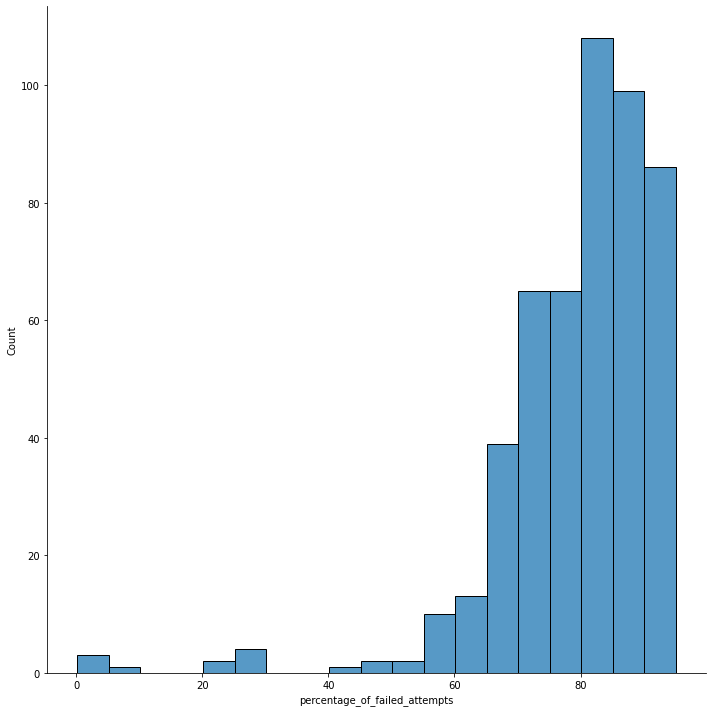

In [17]:
# Построим гитсограмму частот уровней по их доле неудачных попыток

sns.displot(
    table, x="percentage_of_failed_attempts",
    binwidth=5, height=10, facet_kws=dict(margin_titles=True),
)

### Что показывает нам эта гистограмма

Как видно, большая часть сосредоточена в правой стороне. Это означает, что в целом большая часть уровней имеет долю неудачных попыток > 65 % (приблизительно). Также на этом графике можно выделить 3 области. Сделаем разбиение сложностей уровней на основе их количества (причастности к одной из областей):

**Сложность уровней:**

*   [0:65) - Легкий
*   [65:80) - Средний
*   [80:100] - Сложный

**Пояснение принятия такого решения:**

На гистограмме видна положительная корелляция между количеством уровней и процентом доли неудачных попыток (левую часть нет смысла рассматривать, т.к. в основном туда попали первые уровни, а они должны быть очень легкими, для того чтобы не спугнуть игрока в самом начале). Если повышается наша метрика, то и увеличивается количестов уровней. Из этого следует мое предположение о том, что можно соотнести сложность уровней с их количеством (в конце у нас начинается спад, но я думаю это обусловлено тем, что количество настолько сложных уровней должно понижаться, чтобы игрок не бросил это дело).

В целом можно было бы разделить уровни только на две категории (легкие и сложные), но я считаю, что правильней было бы найти так называемую золотую середину, где у игрока с одной стороны есть реальные шансы пройти этот уровень без хэлперов (чтобы он сам понимал, что может пройти его без подручных средств), но в то же время был соблазн "добить" его с помощью покупки внутриигровых бонусов (или с помощью просмотра контекстной рекламы).

In [18]:
# Присвоим класс сложности для каждого уровня

table["class_of_level"] = table["percentage_of_failed_attempts"] \
.apply(lambda x: "Легкий" if x >= 0 and x < 65 else ("Средний" if x >= 65 and x < 80 else "Сложный"))

In [19]:
# Посчитаем, сколько уровней в каждом классе

table.value_counts("class_of_level")

class_of_level
Сложный    293
Средний    169
Легкий      38
dtype: int64

In [20]:
# В процентном соотношении

table.value_counts("class_of_level", normalize = True) * 100

class_of_level
Сложный    58.6
Средний    33.8
Легкий      7.6
dtype: float64

### **Задача 3. Рассчитаем "воронку" прохождения уровней новым пользователем после установки игры.**

Данный анализ позволит увидеть нам до каких вообще уровней доходят наши новые игроки. Приступим!

Для начала отберем только тех игроков в датасете, по которым есть информация о прохождение ими первого уровня (их и будем считать новыми пользователями).

In [21]:
list_of_new_players = df.query("level == 1")["uid"].unique()
list_of_new_players.size

# 24162 новых ползователей

24162

In [22]:
# Посмотрим в каком временном промежутке у нас появилось такое количество новых пользователей

df["date"] = pd.to_datetime(df.event_time / 1000, unit="s")
min_date = df.date.min()
max_date = df.date.max()

In [23]:
list([min_date, max_date])

# 24162 новых пользователей в период с 01.12.2017 до 31.12.2017

[Timestamp('2017-12-01 00:00:00.272000'),
 Timestamp('2017-12-31 23:59:59.867000064')]

In [24]:
# Создадим новую табличку, включающую только новых пользователей

df_with_new_players = df[df["uid"].isin(list_of_new_players)]
df_with_new_players.head(5)

,uid,action,level,event_time,date
41,ajZkQU9zSDQ5Mzk0NjE3MTAyMjExMA,1,9,1512159325078,2017-12-01 20:15:25.078000128
42,ajZkQU9zSDQ5Mzk0NjE3MTAyMjExMA,0,8,1512159325078,2017-12-01 20:15:25.078000128
43,ajZkQU9zSDQ5Mzk0NjE3MTAyMjExMA,0,7,1512159325078,2017-12-01 20:15:25.078000128
44,ajZkQU9zSDQ5Mzk0NjE3MTAyMjExMA,1,7,1512153721854,2017-12-01 18:42:01.854000128
45,ajZkQU9zSDQ5Mzk0NjE3MTAyMjExMA,1,7,1512153721854,2017-12-01 18:42:01.854000128


In [25]:
# Находим максимальный уровень, до которого дошел каждый игрок за данный временной промежуток

max_level_of_new_players = df_with_new_players.groupby("uid", as_index = False).agg({"level" : [max]})
max_level_of_new_players.head(5)

,uid,level
,,max
0,M001TWRFNWc5MjQ1MDI3MTAyMjE5MA,151
1,M001VTlGalU5MzcwMTI3MTAyMjE5Mg,23
2,M010Z2VmOFgzMzgwMTI3MTAyMjE4Mg,33
3,M01QQlBMVmo1NTcyODA3MTAyMjE4MQ,69
4,M01TMDNDdzA0MDkwNzE3MTAyMjE2MA,55


In [30]:
# Количество новых пользователей и размер полученной таблицы совпадают.

max_level_of_new_players.shape

(24162, 2)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2356: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left,1 on the right)
  right_index=True,


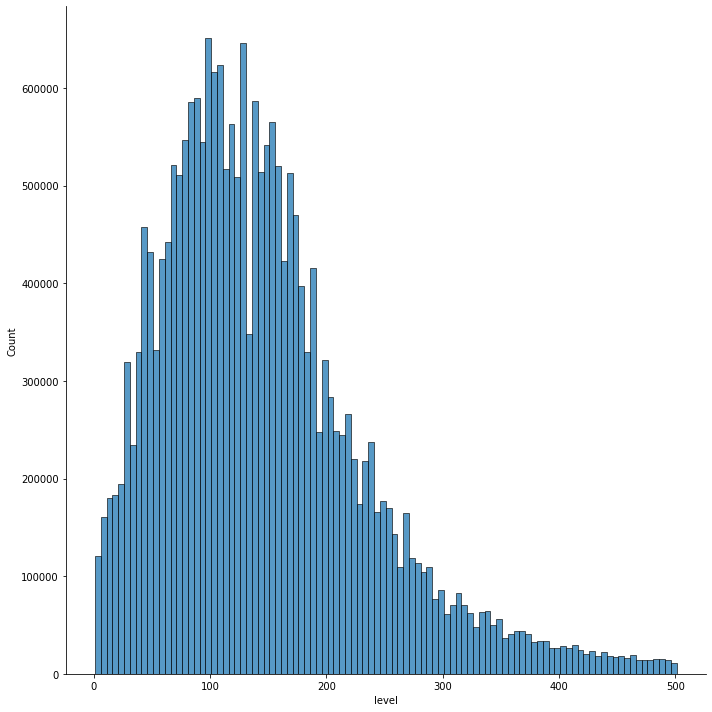

In [26]:
# Построим распределение прохождения уровней новым пользователем после установки игры (за месяц)

sns.displot(
    max_level_of_new_players, x=df["level"],
    binwidth=5, height=10, facet_kws=dict(margin_titles=True),
)

In [27]:
# Узнаем, на каком промежутке находится 95 % наших наблюдений

max_level_of_new_players.quantile([0.0, 0.95])

# 95 % новых пользователей доходит до уровня, принадлежащему промежутку [1:127]

,level
,max
0.00,1.0
0.95,127.0


In [28]:
# Узнаем, на каком промежутке находится 99 % наших наблюдений

max_level_of_new_players.quantile([0.0, 0.99])

# 99 % новых пользователей доходит до уровня, принадлежащему промежутку [1:193]

,level
,max
0.00,1.0
0.99,193.0


## **Отчет по проведенному исследованию**


---


В ходе проведеннего анализа была высчитана метрика для описания сложности уровней, а так же каждому уровню присвоен соответствующий класс сложности. 

При построении распределения прохождения уровней новыми пользователями было обнаружено, что 95 % новых пользователей проходят до уровня, находящегося в промежутке [1:127], а 99 % пользователей - до уровня в промежутке [1:193].

Мои общие рекомендации, предложения для улучшения показателей:



1.   Сократить количество сложных уровней, переведя их в категорию сложности "средний". На данный момент количество сложных уровней сильно преобладает над количеством "средних" и "легких";
2.   На основе этих изменений следить за воронкой прохождения уровней новыми пользователеми. Нужно стремиться к смещению графика  вправо (ситуации, когда игрок проходит от силы несколько уровней - уменьшалась; максимальный уровень, пройденным им - увеличивался);
3.   Возможно, некоторых игроков может смущать реклама в самом начале, и поэтому предлагаю рассмотреть вариант ее уменьшения на начальных уровнях, а потом дать ее игроку в качестве инструмента, чтобы получать хэлперы для более сложных уровней (ненавязчивая реклама).

